In [ ]:
import numpy as np
import pandas as pd

In [ ]:
!wget http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images.zip

--2021-02-21 13:22:35--  http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images.zip
Resolving vision.cs.utexas.edu (vision.cs.utexas.edu)... 128.83.120.116
Connecting to vision.cs.utexas.edu (vision.cs.utexas.edu)|128.83.120.116|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 305323328 (291M) [application/zip]
Saving to: ‘ut-zap50k-images.zip’

ut-zap50k-images.zi 100%[===================>] 291.18M  68.5MB/s    in 4.5s    

2021-02-21 13:22:39 (64.5 MB/s) - ‘ut-zap50k-images.zip’ saved [305323328/305323328]



In [ ]:
!unzip ut-zap50k-images.zip

In [ ]:
meta = pd.read_csv("meta-data.csv")

In [ ]:
meta.head()

,CID,Category,SubCategory,HeelHeight,Insole,Closure,Gender,Material,ToeStyle
0,100627-72,Shoes,Oxfords,NaN,Leather,Lace up,Men,Leather,Capped Toe;Round Toe
1,100627-255,Shoes,Oxfords,NaN,Leather,Lace up,Men,Leather,Capped Toe;Round Toe
2,100657-72,Shoes,Oxfords,NaN,Leather;Padded;Removable,Lace up,Men,Leather,Capped Toe;Round Toe
3,100657-216,Shoes,Oxfords,NaN,Leather;Padded;Removable,Lace up,Men,Leather,Capped Toe;Round Toe
4,101026-3,Boots,Mid-Calf,1in - 1 3/4in,Leather;Padded,Pull-on,Men,Leather;Rubber,Square Toe;Closed Toe


In [ ]:
import os
from collections import defaultdict

folder = "ut-zap50k-images"
classes = {}
numofpics = defaultdict(int)
img_paths = []
count = 0
for cat in os.listdir(folder):
  folder1 = folder + "/" + cat
  for subcat in os.listdir(folder1):
    folder2 = folder1 + "/" + subcat
    classes[cat + ", " + subcat] = count
    classes[count] = cat + ", " + subcat
    count += 1
    for brand in os.listdir(folder2):
      folder3 = folder2 + "/" + brand
      for pic in os.listdir(folder3):
        numofpics[cat + "-" + subcat] += 1
        img_paths.append(folder3 + "/" + pic)

In [ ]:
classes

{0: 'Sandals, Flat',
 1: 'Sandals, Heel',
 10: 'Shoes, Boat Shoes',
 11: 'Shoes, Firstwalker',
 12: 'Shoes, Sneakers and Athletic Shoes',
 13: 'Slippers, Boot',
 14: 'Slippers, Slipper Heels',
 15: 'Slippers, Slipper Flats',
 16: 'Boots, Knee High',
 17: 'Boots, Mid-Calf',
 18: 'Boots, Prewalker Boots',
 19: 'Boots, Over the Knee',
 2: 'Sandals, Athletic',
 20: 'Boots, Ankle',
 3: 'Shoes, Heels',
 4: 'Shoes, Crib Shoes',
 5: 'Shoes, Flats',
 6: 'Shoes, Oxfords',
 7: 'Shoes, Clogs and Mules',
 8: 'Shoes, Prewalker',
 9: 'Shoes, Loafers',
 'Boots, Ankle': 20,
 'Boots, Knee High': 16,
 'Boots, Mid-Calf': 17,
 'Boots, Over the Knee': 19,
 'Boots, Prewalker Boots': 18,
 'Sandals, Athletic': 2,
 'Sandals, Flat': 0,
 'Sandals, Heel': 1,
 'Shoes, Boat Shoes': 10,
 'Shoes, Clogs and Mules': 7,
 'Shoes, Crib Shoes': 4,
 'Shoes, Firstwalker': 11,
 'Shoes, Flats': 5,
 'Shoes, Heels': 3,
 'Shoes, Loafers': 9,
 'Shoes, Oxfords': 6,
 'Shoes, Prewalker': 8,
 'Shoes, Sneakers and Athletic Shoes': 12,
 

In [ ]:
numofpics

defaultdict(int,
            {'Boots-Ankle': 5855,
             'Boots-Knee High': 2202,
             'Boots-Mid-Calf': 4724,
             'Boots-Over the Knee': 49,
             'Boots-Prewalker Boots': 2,
             'Sandals-Athletic': 14,
             'Sandals-Flat': 5601,
             'Sandals-Heel': 126,
             'Shoes-Boat Shoes': 629,
             'Shoes-Clogs and Mules': 1427,
             'Shoes-Crib Shoes': 23,
             'Shoes-Firstwalker': 369,
             'Shoes-Flats': 3994,
             'Shoes-Heels': 5703,
             'Shoes-Loafers': 2875,
             'Shoes-Oxfords': 2044,
             'Shoes-Prewalker': 249,
             'Shoes-Sneakers and Athletic Shoes': 12856,
             'Slippers-Boot': 14,
             'Slippers-Slipper Flats': 1259,
             'Slippers-Slipper Heels': 10})

In [ ]:
print(len(img_paths), *img_paths[:5], sep="\n")

50025
ut-zap50k-images/Sandals/Flat/Sbicca/8088274.14.jpg
ut-zap50k-images/Sandals/Flat/Sbicca/7990457.30403.jpg
ut-zap50k-images/Sandals/Flat/Sbicca/7990211.30403.jpg
ut-zap50k-images/Sandals/Flat/Sbicca/8023073.19.jpg
ut-zap50k-images/Sandals/Flat/Sbicca/7990220.711.jpg


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from skimage import io
import re
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [ ]:
def load_img(path):
  transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  pic = Image.open(path)
  pic = pic.convert('RGB')
  pic = transform(pic)
  return pic

In [ ]:
def get_label(img_path, meta):
  crop = re.search(r"/[0-9]+.[0-9]+", img_path).group(0)[1:]
  code = crop.replace('.','-')
  label = ""
  try:
    label = ", ".join(np.array(meta.loc[meta['CID'] == code])[0][1:3])
  except:
    print(img_path, code, np.array(meta.loc[meta['CID'] == code]))
  return label

In [ ]:
img_path = "/content/ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/Levi's&#174; Kids/7832143.275.jpg"
# get_label(img_path, meta)
re.search(r"/[0-9]+.[0-9]+", img_path).group(0)[1:]

'7832143.275'

In [ ]:
class ShoesDataset(Dataset):
  def __init__(self, csv_path, img_paths, transform=None):
        """
        Args:
            csv_path (string): csv file with labels.
            img_paths (list): List of all images' path names.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_path = csv_path
        self.img_paths = img_paths
        self.transform = transform

  def __len__(self):
      return len(self.img_paths)

  def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()
      
      meta = pd.read_csv(self.csv_path)
      img_path = self.img_paths[idx]
      img = io.imread(img_path)
      label = classes[get_label(img_path, meta)]

      if self.transform:
          img = self.transform(img)

      return [img, label]


ds length = 50025
0 torch.Size([3, 102, 136]) 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 torch.Size([3, 102, 136]) 0
2 torch.Size([3, 102, 136]) 0


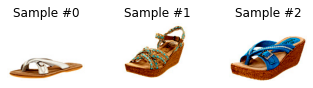

In [ ]:
transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

ds = ShoesDataset("meta-data.csv", img_paths, transform)
print(f"ds length = {len(ds)}")

for i in range(3):
  sample = ds[i]

  print(i, sample[0].shape, sample[1])

  ax = plt.subplot(1, 4, i + 1)
  plt.tight_layout()
  ax.set_title('Sample #{}'.format(i))
  ax.axis('off')
  plt.imshow(sample[0].permute(1, 2, 0))
  
  if i == 3:
    plt.show()
    break

In [ ]:
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
trainset, testset = torch.utils.data.random_split(ds, [train_size, test_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                          shuffle=True, num_workers=1, )
testloader = torch.utils.data.DataLoader(testset, batch_size=50,
                                         shuffle=False, num_workers=1)


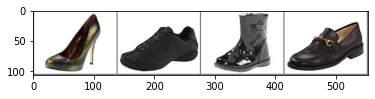

tensor([ 3, 12, 17,  9])


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(labels)

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=5)) # convolution
model.add_module('bn_conv1', nn.BatchNorm2d(32))
model.add_module('conv1_relu', nn.ReLU())

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, dilation=3)) # convolution
model.add_module('bn_conv2', nn.BatchNorm2d(32))
model.add_module('conv2_relu', nn.ReLU())

model.add_module('pool1', nn.MaxPool2d(kernel_size=2, stride=1, padding=1))

model.add_module('flat', Flatten())
model.add_module('dense1', nn.Linear(9408, 1024))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dropout0', nn.Dropout(0.3))
model.add_module('dense2', nn.Linear(1024, 21))

In [ ]:
from torchsummary import summary
summary(model.cuda(),(3,102,136))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 20, 27]             896
       BatchNorm2d-2           [-1, 32, 20, 27]              64
              ReLU-3           [-1, 32, 20, 27]               0
            Conv2d-4           [-1, 32, 14, 21]           9,248
       BatchNorm2d-5           [-1, 32, 14, 21]              64
              ReLU-6           [-1, 32, 14, 21]               0
         MaxPool2d-7           [-1, 32, 14, 21]               0
           Flatten-8                 [-1, 9408]               0
            Linear-9                 [-1, 1024]       9,634,816
             ReLU-10                 [-1, 1024]               0
          Dropout-11                 [-1, 1024]               0
           Linear-12                   [-1, 21]          21,525
Total params: 9,666,613
Trainable params: 9,666,613
Non-trainable params: 0
---------------------------

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss = []
val_accuracy = []

In [ ]:
def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch)).cuda()
    y_batch = Variable(torch.LongTensor(y_batch)).cuda()
    logits = model.cuda()(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [ ]:
count = 0
for x,y in trainloader:
  count += 1
  # if count % 100 == 0:
  print(count)

In [ ]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration


for epoch in range(num_epochs):
    print (num_epochs)
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in trainloader:
        # train on batch
        print(1)
        loss = compute_loss(X_batch, y_batch)
        print()
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy())
    print (num_epochs)    
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in testloader:
        logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    print (num_epochs)
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_dataset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(val_dataset) // batch_size :]) * 100))

100
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5


KeyboardInterrupt: ignored

In [ ]:
meta.loc[meta['CID'] == "8022041-89"]

,CID,Category,SubCategory,HeelHeight,Insole,Closure,Gender,Material,ToeStyle
36065,8022041-89,Boots,Mid-Calf,Flat,Leather,Zipper,Girls,Leather;Faux Fur,Round Toe;Closed Toe
